# Identifiability and Frontdoor Adjustment Formula

This notebook explores identifiability via the IdentifiabiltyChecker, for the simple triangle graph
with nodes X, M, Y, U and arrows X->M->Y and X<-U->Y.

We verify that the Frontdoor Adjustmen Formula is satisfied.

In [1]:
# this makes sure it starts looking for things from the JudeasRx folder down.
import os
import sys
os.chdir('../')
sys.path.insert(0,os.getcwd())
print(os.getcwd())

/home/rrtucci/PycharmProjects/JudeasRx


In [2]:
from DoX_BayesNet import DoX_BayesNet
import DoX_BayesNet
from graphs.BayesNet import *
from nodes.BayesNode import *
from IdentifiabilityChecker import IdentifiabilityChecker
import IdentifiabilityChecker
import imp
from pprint import pprint
import copy as cp
%matplotlib inline

In [3]:
# this cell is for development purposes. Rerun this
# every time there are changes to the code,
# instead of restarting the kernel, which takes much longer.
imp.reload(DoX_BayesNet)
imp.reload(IdentifiabilityChecker)

<module 'IdentifiabilityChecker' from '/home/rrtucci/PycharmProjects/JudeasRx/IdentifiabilityChecker.py'>

In [4]:
def print_bnet(bnet):
    for nd in bnet.nodes:
        print(nd.name, ", parents=" + str([x.name for x in nd.parents]),
              ", children=" + str([x.name for x in nd.children]))
        print(nd.potential)
        print(nd.potential.pot_arr)
        print()

## Building in_bnet

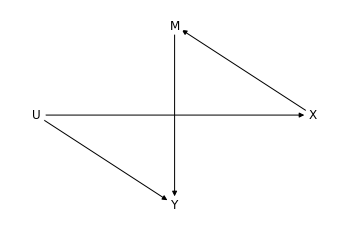

X , parents=['U'] , children=['M']
['U', 'X']
[[0.721 0.279]
 [0.951 0.049]]
[[0.721 0.279]
 [0.951 0.049]]

U , parents=[] , children=['X', 'Y']
['U']
[0.333 0.667]
[0.333 0.667]

Y , parents=['U', 'M'] , children=[]
['M', 'U', 'Y']
[[[0.361 0.639]
  [0.034 0.966]]

 [[0.341 0.659]
  [0.595 0.405]]]
[[[0.361 0.639]
  [0.034 0.966]]

 [[0.341 0.659]
  [0.595 0.405]]]

M , parents=['X'] , children=['Y']
['X', 'M']
[[0.626 0.374]
 [0.679 0.321]]
[[0.626 0.374]
 [0.679 0.321]]



In [5]:
def build_in_bnet(draw=True):
    nd_X = BayesNode(0, name="X")
    nd_M = BayesNode(1, name="M")
    nd_Y = BayesNode(2, name="Y")
    nd_U = BayesNode(3, name="U")

    nd_Y.add_parents({nd_M, nd_U})
    nd_M.add_parents({nd_X})
    nd_X.add_parents({nd_U})

    nodes = {nd_X, nd_M, nd_Y, nd_U}
    in_bnet = BayesNet(nodes)

    # in general
    # DiscreteCondPot(False, [y1, y2, y3, x]) refers to P(x| y1, y2, y3)
    nd_U.potential = DiscreteUniPot(False, nd_U)  # P(a)
    nd_X.potential = DiscreteCondPot(False, [nd_U, nd_X])  # P(b| a)
    nd_M.potential = DiscreteCondPot(False, [nd_X, nd_M]) 
    nd_Y.potential = DiscreteCondPot(False, [nd_M, nd_U, nd_Y])
    for nd in nodes:
        nd.potential.set_to_random()
        nd.potential.normalize_self()
    if draw:
        in_bnet.draw(algo_num=1)
    return in_bnet

    
in_bnet = build_in_bnet(True)
print_bnet(in_bnet)

Frontdoor Adjustment Formula:
$$P(Y=1|do(X)=0) = \sum_m \left[\sum_{x'} P(y=1|m, x')P(x')\right]P(m|x=0)$$

In [6]:
nd_U = in_bnet.get_node_named("U")
nd_M = in_bnet.get_node_named("M")
nd_Y = in_bnet.get_node_named("Y")
nd_X = in_bnet.get_node_named("X")

pot_XYMU = nd_X.potential*nd_Y.potential*nd_M.potential*nd_U.potential
pot_XYM = pot_XYMU.get_new_marginal([nd_X, nd_Y, nd_M])
pot_XM = pot_XYM.get_new_marginal([nd_X, nd_M])
pot_X = pot_XM.get_new_marginal([nd_X])

pot_YXbM = (pot_XYM/pot_XM)*pot_X
pot_YbM = pot_YXbM.get_new_marginal([nd_Y, nd_M])
pot_MbX= nd_M.potential
pot_YMbX = pot_YbM*pot_MbX
pot_YbX = pot_YMbX.get_new_marginal([nd_Y, nd_X])
pot_YbX.set_to_transpose([nd_X, nd_Y])
frontdoor_pot_YbX= pot_YbX.pot_arr
print(frontdoor_pot_YbX)

[[0.280 0.720]
 [0.261 0.739]]


## Building doX bnet

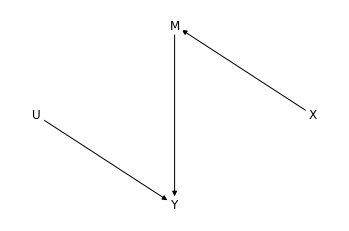

X , parents=[] , children=['M']
['X']
[1.000 0.000]
[1.000 0.000]

U , parents=[] , children=['Y']
['U']
[0.333 0.667]
[0.333 0.667]

Y , parents=['U', 'M'] , children=[]
['M', 'U', 'Y']
[[[0.361 0.639]
  [0.034 0.966]]

 [[0.341 0.659]
  [0.595 0.405]]]
[[[0.361 0.639]
  [0.034 0.966]]

 [[0.341 0.659]
  [0.595 0.405]]]

M , parents=['X'] , children=['Y']
['X', 'M']
[[0.626 0.374]
 [0.679 0.321]]
[[0.626 0.374]
 [0.679 0.321]]



In [7]:
trol_list = []
unobs_nd_list = []
doX_bnet = DoX_BayesNet.DoX_BayesNet(in_bnet,
                        trol_list,
                        unobs_nd_list,
                        x_val=0)
doX_bnet.draw(algo_num=1)
print_bnet(doX_bnet)

## Node U is unobserved, no control nodes

In [8]:
nd_U = in_bnet.get_node_named("U")
trol_list = []
unobs_nd_list = [nd_U]
doX_bnet.set_trol_and_unobs_nodes(trol_list, unobs_nd_list)
checker = IdentifiabilityChecker.IdentifiabilityChecker(doX_bnet,
                          num_1world_samples=10000,
                          num_worlds=100)
checker.set_query_bds_and_stats()
print("control nodes:",
      [nd.name for nd in checker.trol_list])
print("control coords to query bounds (low, high):")
pprint(dict(checker.get_query_bds()))
print("control coords to query statistics (mu, sigma):")
pprint(dict(checker.get_query_stats()))

world:
0, 1, 2, 3, 4, 5, 6, 7, 8, 9
10, 11, 12, 13, 14, 15, 16, 17, 18, 19
20, 21, 22, 23, 24, 25, 26, 27, 28, 29
30, 31, 32, 33, 34, 35, 36, 37, 38, 39
40, 41, 42, 43, 44, 45, 46, 47, 48, 49
50, 51, 52, 53, 54, 55, 56, 57, 58, 59
60, 61, 62, 63, 64, 65, 66, 67, 68, 69
70, 71, 72, 73, 74, 75, 76, 77, 78, 79
80, 81, 82, 83, 84, 85, 86, 87, 88, 89
90, 91, 92, 93, 94, 95, 96, 97, 98, 99
control nodes: []
control coords to query bounds (low, high):
{(): array([0.650, 0.753])}
control coords to query statistics (mu, sigma):
{(): array([0.698, 0.026])}


In [9]:
# entry (0,1) of the following matrix is the Frontdoor Adjustment Formula prediction
# for mean mu in "control coords to query statistics" above.
print(frontdoor_pot_YbX)

[[0.280 0.720]
 [0.261 0.739]]
